In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from TVL2 import *
from TVICE import logerfc, logerf2
import warnings 
warnings.filterwarnings('ignore')

# TV - Iterated Conditional Expectation

Ce notebook porte sur le débruitage d'images grâce à l'algorithme *Iterated Conditional Expectation*. Il est inspiré de l'article

[Louchet, C.,  Moisan, L., *Total variation denoising using iterated conditional expectation*. In 2014 22nd European Signal Processing Conference (EUSIPCO) (pp. 1592-1596). 2014](https://hal.archives-ouvertes.fr/hal-01214735)

Voir le sujet PDF associé pour plus de détails.

In [2]:
lambd = 20   # TV regularization parameter 
sig = 0.07  # noise standard deviation

In [8]:
# image creation
n = 500    # start with small images for your experimentations
i = 100
u = plt.imread('./img/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sig*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sig**2*lambd,100)

In [4]:
def get_vectors(u, col_idx):
    a = np.zeros((u.shape[0]))
    b = np.zeros((u.shape[0]))
    c = np.zeros((u.shape[0]))
    d = np.zeros((u.shape[0]))
    
    n = u.shape[0]
    m = u.shape[1]
    
    for i in range(u.shape[0]):
    
        current = u[i, col_idx]
        neighbors = np.zeros((4))
        
        neighbors[0] = u[(i - 1) % n, col_idx]
        neighbors[1] = u[(i + 1) % n, col_idx]
        neighbors[2] = u[i, (col_idx - 1) % m]
        neighbors[3] = u[i, (col_idx + 1) % m]
        
        neighbors.sort()
        a[i], b[i], c[i], d[i] = neighbors
        
    return a, b, c, d

In [5]:
def tvice(u0,sig,lambd,n_iter=50): 
    """
    Computes the u_ice estimate
    
    Parameters:
    u0: Noisy Image
    sig: sigma parameter
    lambd: lambda parameter
    n_iter: # of iterations to run
    
    Returns:
    Approximation of u_ice the denoised image
    """
    u = np.copy(u0)
    
    history = list()
    
    for iter_idx in range(1, n_iter + 1):
        for i in range(u.shape[1]):
            t = u0[:, i]
            a, b, c, d = get_vectors(u, i)
            
            X_2 = logerfc((t - a + 4*lambd*sig**2)/(sig*np.sqrt(2)))+\
                            (2*lambd*(2*(t + 2*lambd*sig**2) - a - b)) 
            
            X_1 = logerf2((a - t - 2*lambd*sig**2)/(sig*np.sqrt(2)),
                            (b - t - 2*lambd*sig**2)/(sig*np.sqrt(2)))+\
                            lambd*(2*(t - b) + 2*lambd*sig**2)
            
            X0 = logerf2((b-t)/(sig*np.sqrt(2)), (c-t)/(sig*np.sqrt(2)))
            
            X1 = logerf2((c - t + 2*lambd*sig**2)/(sig*np.sqrt(2)),
                            (d - t + 2*lambd*sig**2)/(sig*np.sqrt(2)))+\
                            lambd*(2*(c - t) + 2*lambd*sig**2)
            
            X2 = logerfc((d - t + 4*lambd*sig**2)/(sig*np.sqrt(2)))+\
                            (2*lambd*(c + d - 2*(t - 2*lambd*sig**2))) 
            
            XS = np.array([X_2, X_1, X0, X1, X2])
            M = np.max(XS, axis=0)
            X_2, X_1, X0, X1, X2 = np.exp(XS - M)
            
            ratio = (2*X_2 + X_1 - X1 - 2*X2)/(X_2 + X_1 + X0 + X1 + X2)
            u[:, i] = u0[:, i] + 2*lambd*sig**2*ratio
        history.append(np.copy(u))
    return u, history

<Figure size 720x720 with 0 Axes>

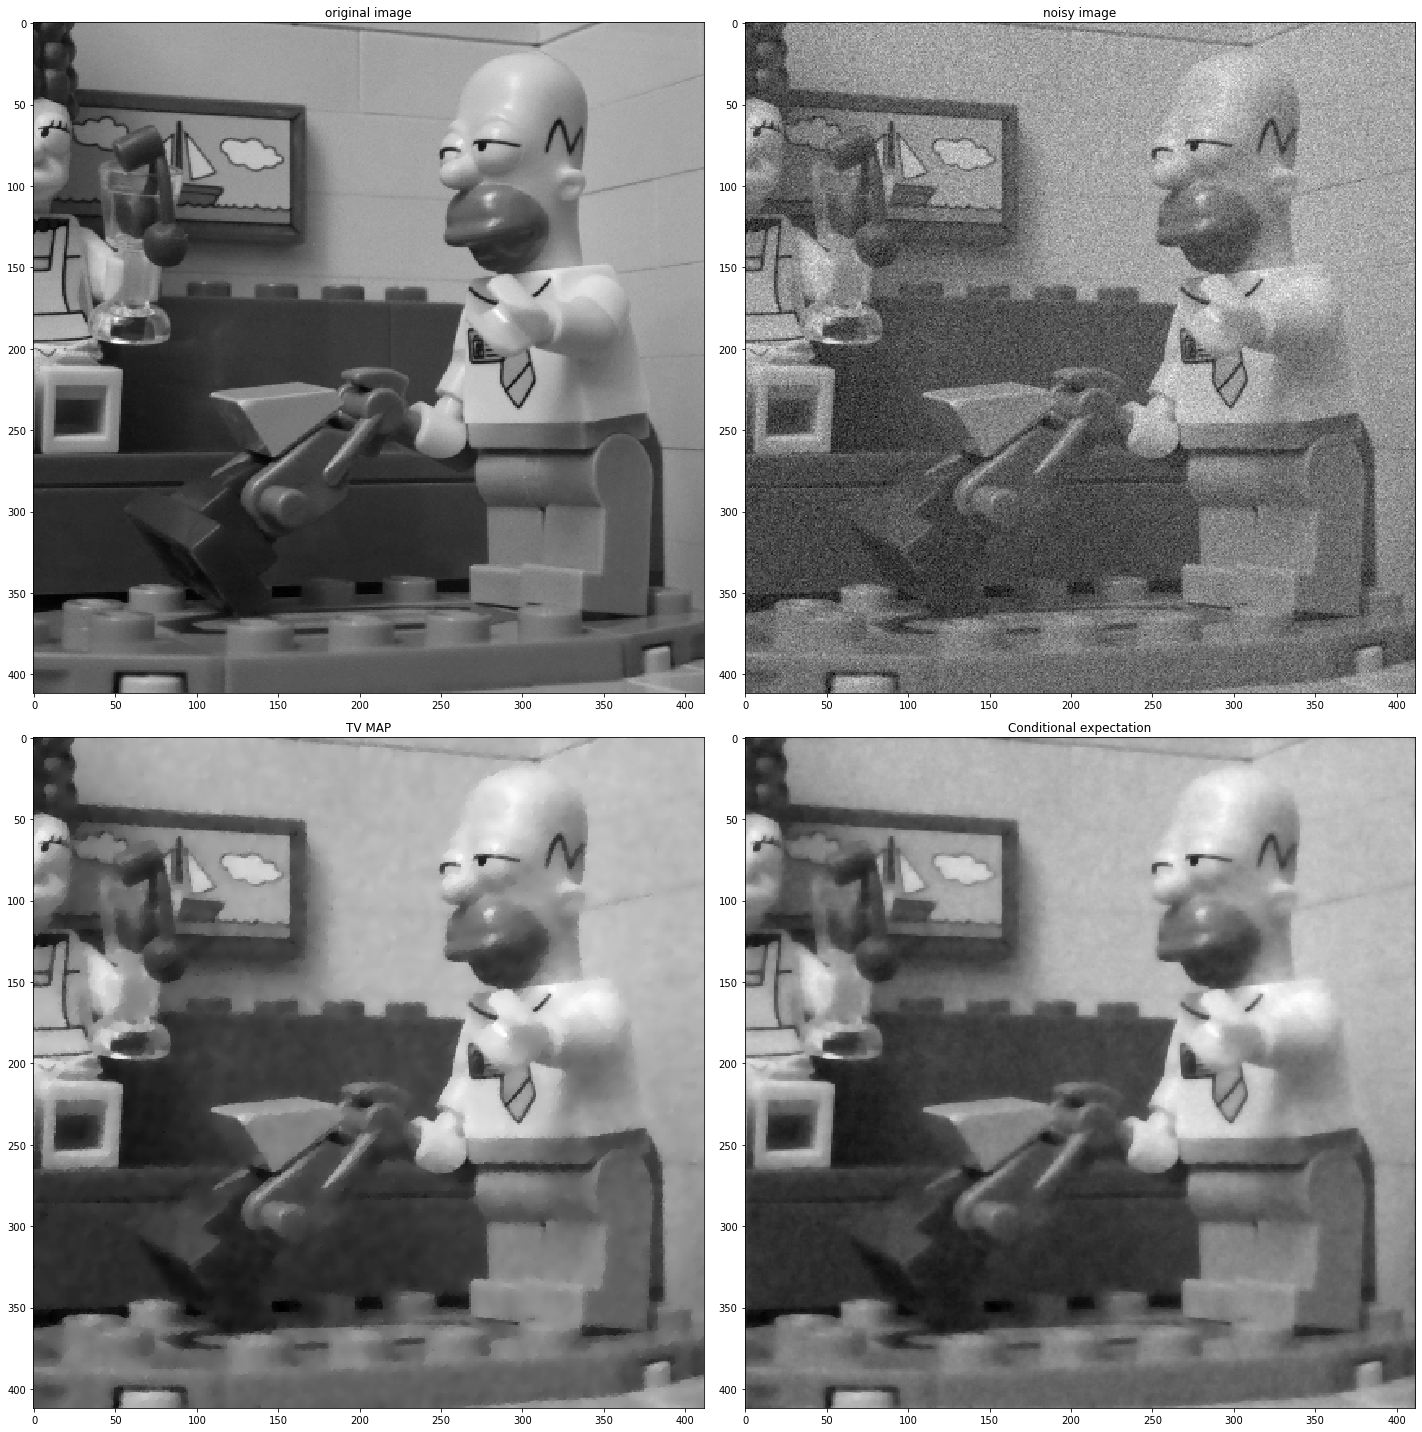

<Figure size 720x720 with 0 Axes>

In [9]:
## denoise ub using the TV-ICE scheme
out, history = tvice(ub, sig, lambd, 100)

## display
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(out,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))

<Figure size 720x720 with 0 Axes>

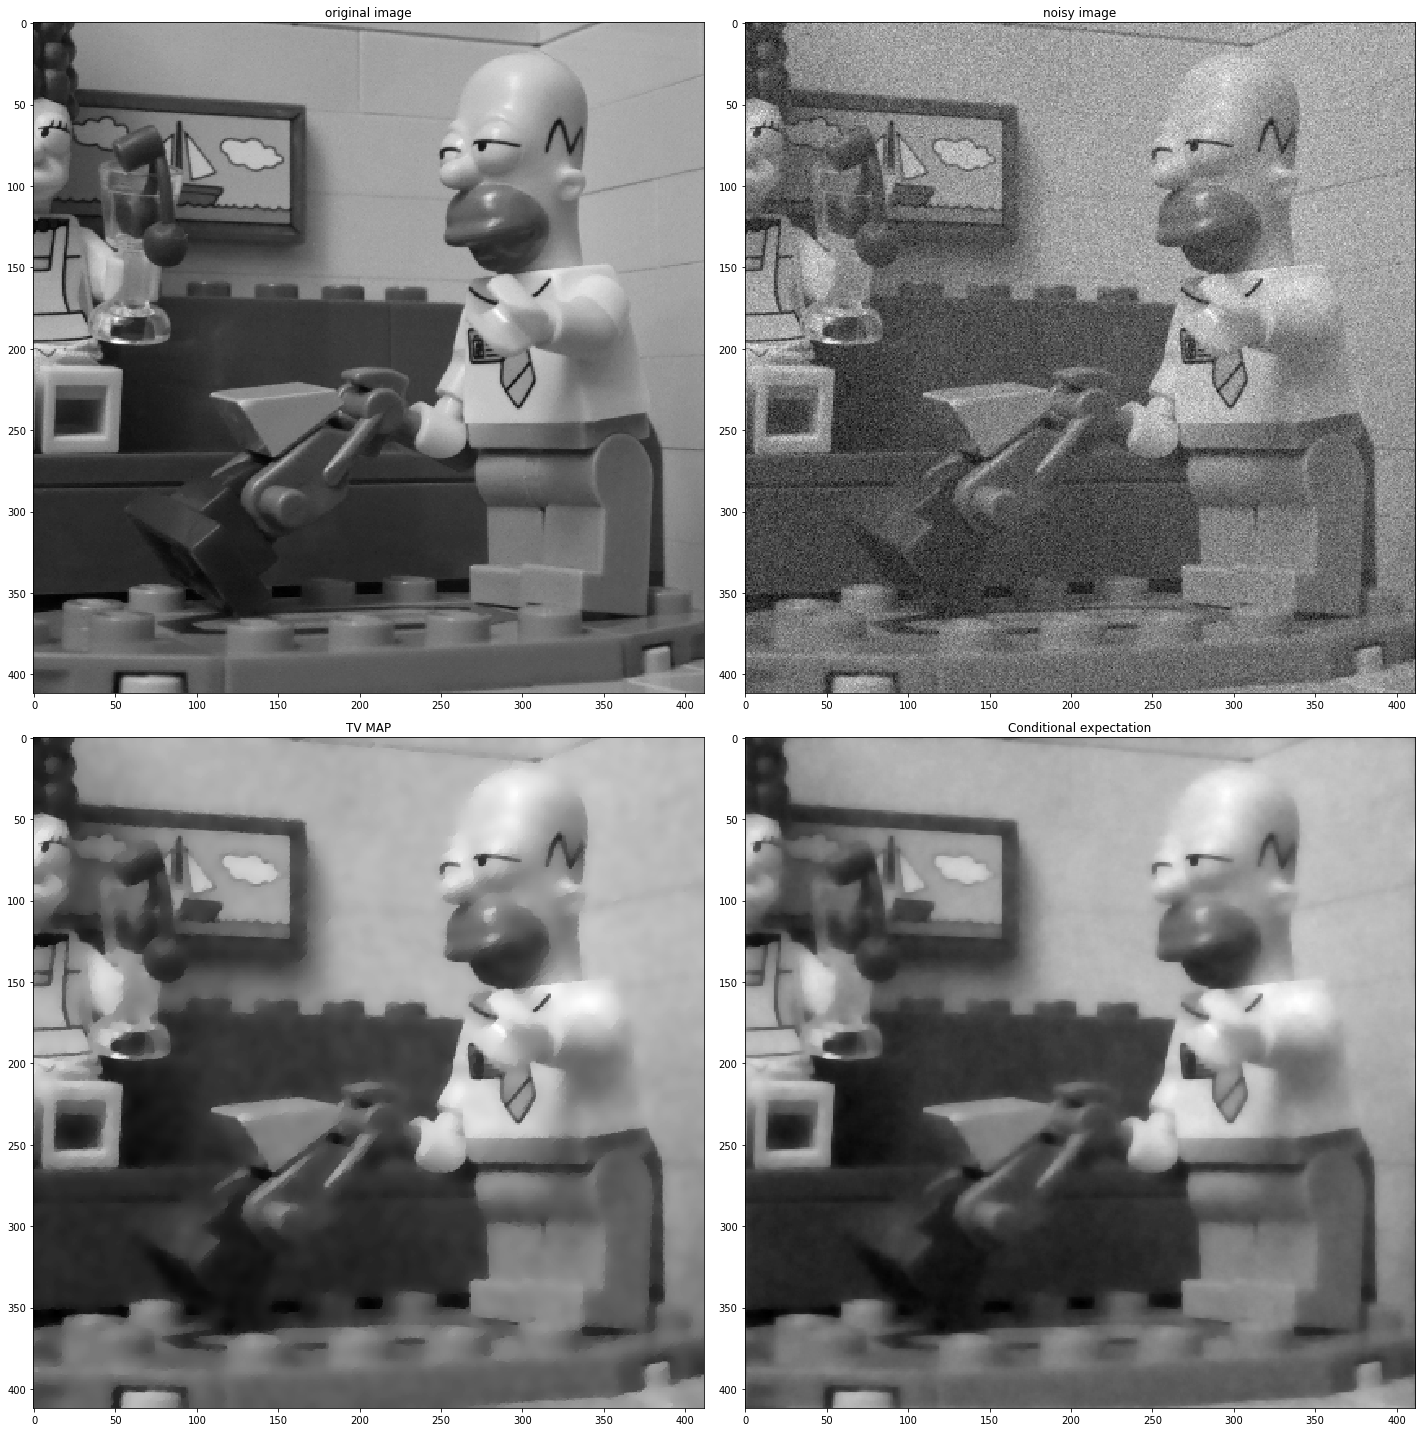

<Figure size 720x720 with 0 Axes>

In [46]:
lambd = 30  # TV regularization parameter 
sig = 0.07  # noise standard deviation
# image creation
n = 500    # start with small images for your experimentations
i = 100
u = plt.imread('./img/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sig*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sig**2*lambd,100)
## denoise ub using the TV-ICE scheme
out, history = tvice(ub, sig, lambd, 100)

## display
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(out,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))

<Figure size 720x720 with 0 Axes>

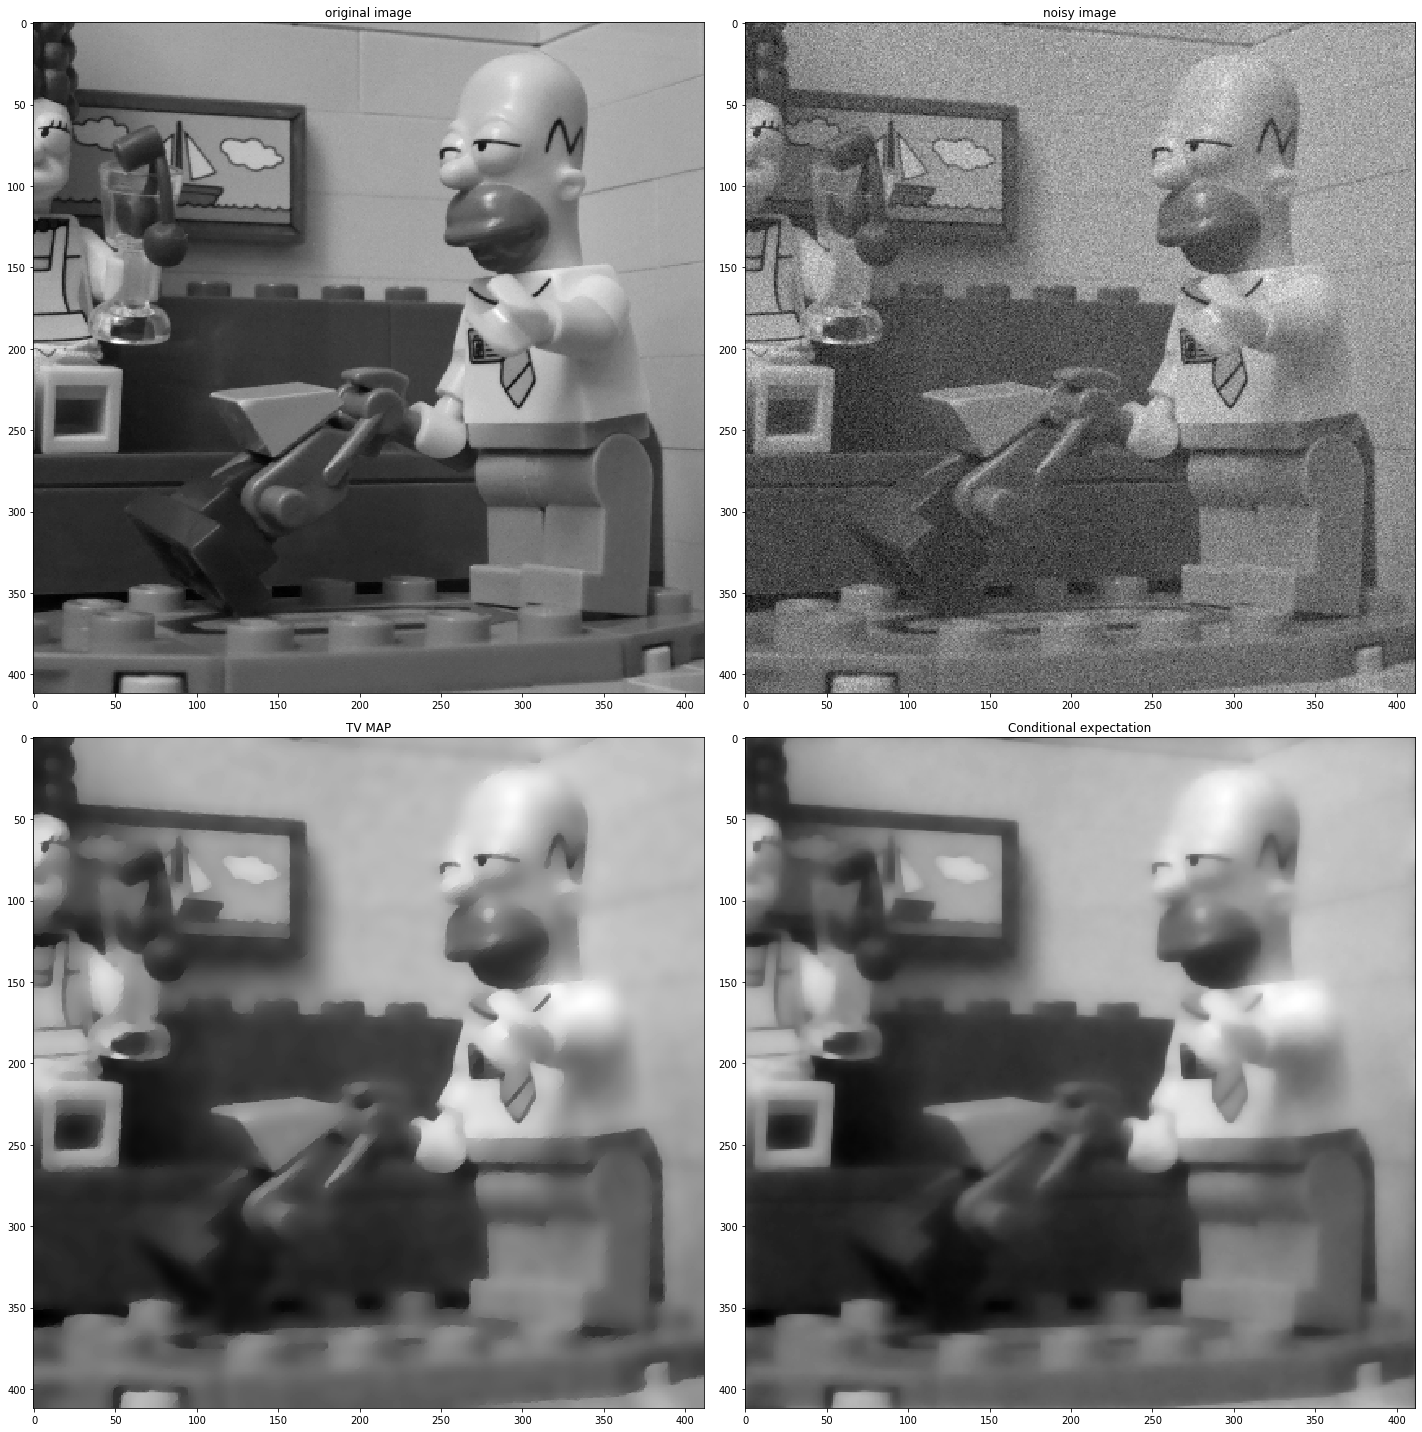

<Figure size 720x720 with 0 Axes>

In [10]:
lambd = 50   # TV regularization parameter 
sig = 0.07  # noise standard deviation
# image creation
n = 500    # start with small images for your experimentations
i = 100
u = plt.imread('./img/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sig*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sig**2*lambd,100)
## denoise ub using the TV-ICE scheme
out, history = tvice(ub, sig, lambd, 100)

## display
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(out,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))

<Figure size 720x720 with 0 Axes>

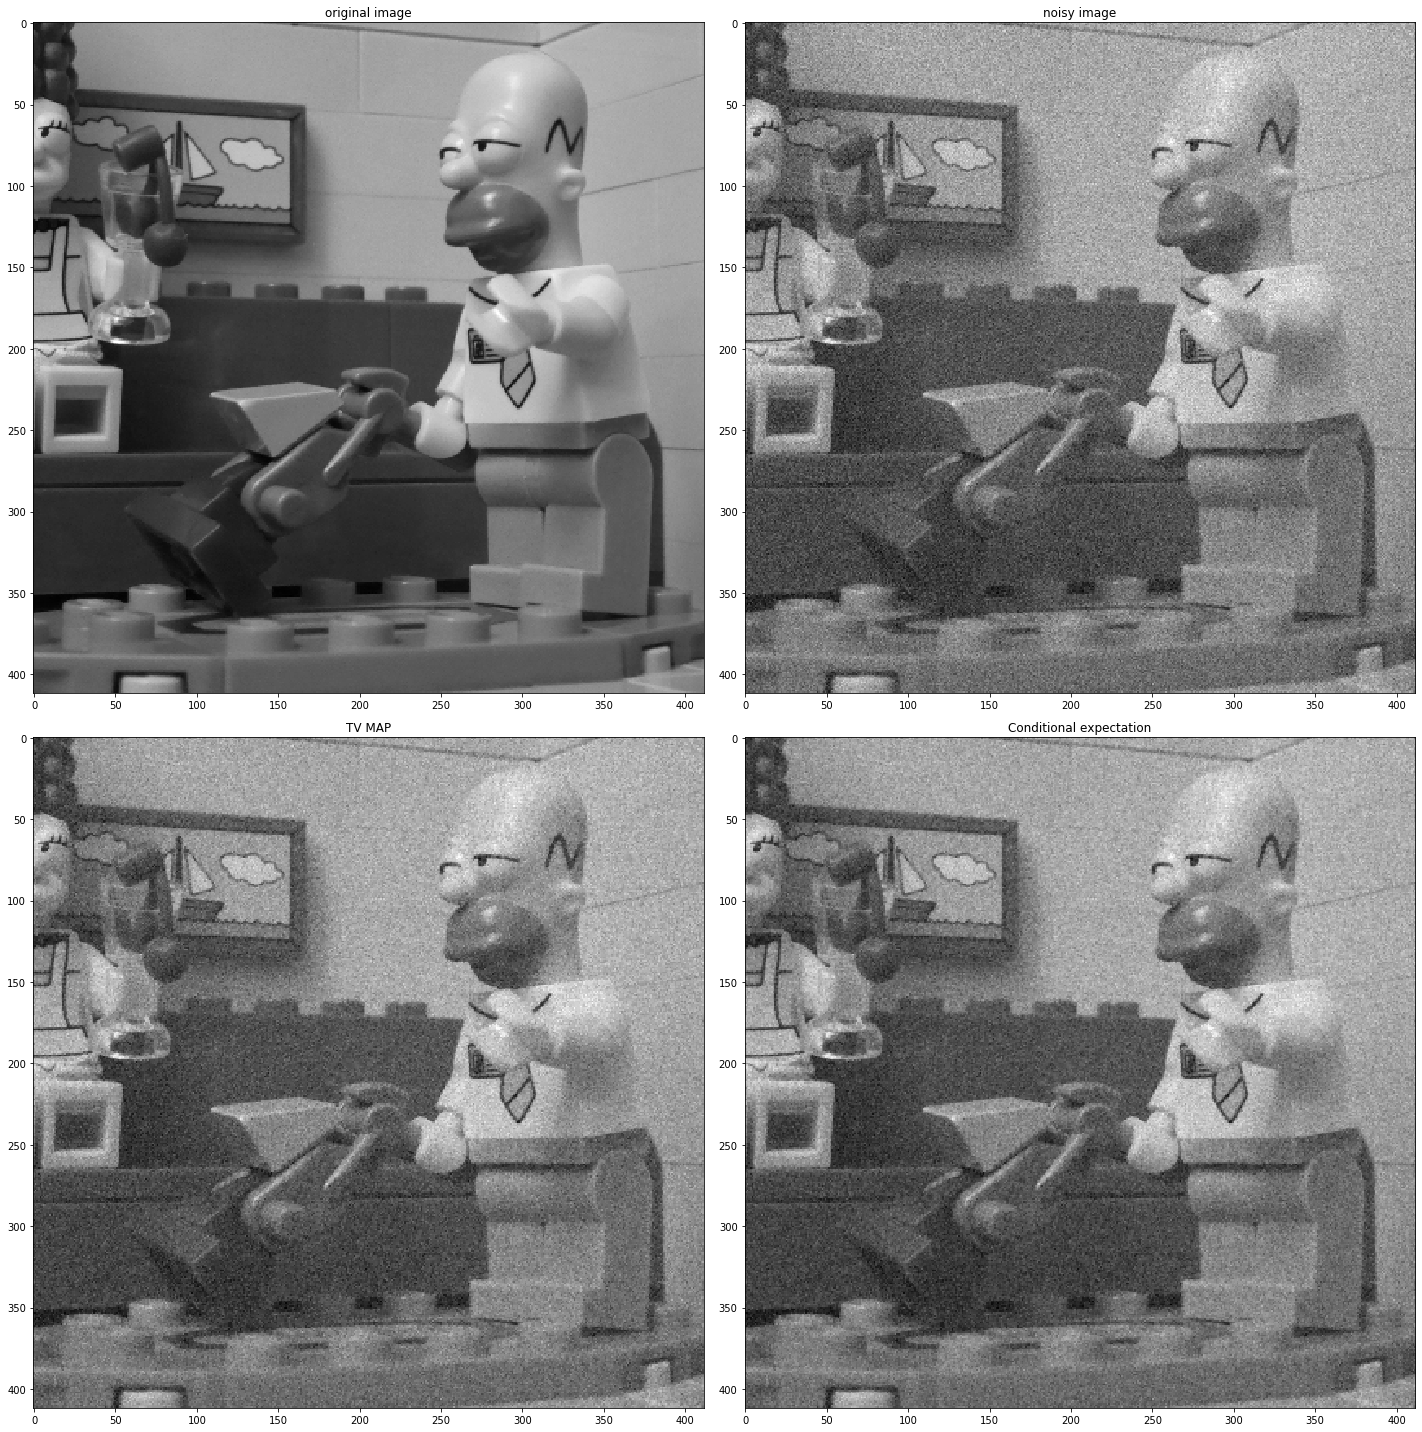

<Figure size 720x720 with 0 Axes>

In [13]:
lambd = 2   # TV regularization parameter 
sig = 0.07  # noise standard deviation
# image creation
n = 500    # start with small images for your experimentations
i = 100
u = plt.imread('./img/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sig*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sig**2*lambd,100)
## denoise ub using the TV-ICE scheme
out, history = tvice(ub, sig, lambd, 100)

## display
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(out,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))

# Answers to the PDF questions

### Question 1: Loi marginale conditionnelle $\pi(u(i)|u(i^c))$

Nous avons l'égalité suivante:
$$
\begin{align}
\pi(u(i)|u(i^c)) &= \frac{\pi(u)}{\pi(u(i^c))} \\
&= \frac{\pi(u)}{\int_\mathbb{R} \pi(x,u(i^c)) dx} \\
\end{align}
$$
Nous pouvons développer l'intégrale pour obtenir:
$$
\begin{align}
\pi(u(i)|u(i^c)) &= \frac{e^{- \frac{1}{2\sigma^2} |u(i) - u_0(i)|^2 - \lambda \sum_{j\in N(i)} |u(i) - u(j)|}}{Z}
\end{align}
$$
avec $Z = \int_\mathbb{R} e^{- \frac{1}{2\sigma^2} |x - u_0(i)|^2 - \lambda \sum_{j\in N(i)} |x - u(j)|}$ 

Ainsi nous avons bien $$ \pi(u(i)|u(i^c)) \propto e^{- \frac{1}{2\sigma^2} |u(i) - u_0(i)|^2 - \lambda \sum_{j\in N(i)} |u(i) - u(j)|} \quad \blacksquare$$ 


### Question 2: Espérance $\mathbb{E}_{U \sim \pi}[U(i)|U(i^c) = w(i^c)]$

Nous avons:
$$
\begin{equation}
\mathbb{E}_{U \sim \pi}[U(i)|U(i^c) = w(i^c)] = \int_\mathbb{R} x \pi(x | w(i^c)) dx
\end{equation}
$$

En utilisant le résultat de la question précédente, nous obtenons:

$$
\begin{align}
\mathbb{E}_{U \sim \pi}[U(i)|U(i^c) = w(i^c)] &= \int_{R} x \frac{\exp(-\frac{1}{2 \sigma^{2}} {|x - u_{0}(i)|}^{2}) \exp(- \lambda \sum_{j \in N(i)} |x - w(j)|)}{Z} dx
\end{align}
$$

avec $Z = \int_\mathbb{R} e^{- \frac{1}{2\sigma^2} |x - u_0(i)|^2 - \lambda \sum_{j\in N(i)} |x - u(j)|}$ 

Rappelons nous que $s = x - u_0(i)$. Nous pouvons appliquer ce changement de variable pour donner:
$$
\begin{align}
\mathbb{E}_{U \sim \pi}[U(i)|U(i^c) = w(i^c)] &= \int_{R} (x - u_0(i) + u_0(i)) \frac{\exp(-\frac{1}{2 \sigma^{2}} s^2) \exp(- \lambda \sum_{j \in N(i)} |s + u_0(i) - w(j)|)}{Z} dx \\
&= u_0(i) + \int_{R} s \frac{\exp(-\frac{1}{2 \sigma^{2}} s^2) \exp(- \lambda \sum_{j \in N(i)} |s + u_0(i) - w(j)|)}{Z} ds \\
&= u_0(i) + \frac{1}{Z} \int_{R} s \exp(-\frac{1}{2 \sigma^{2}} s^2) \exp(- \lambda \sum_{j \in N(i)} |s + u_0(i) - w(j)|) ds \quad \blacksquare
\end{align}
$$


# Question 3: Algorithme TV-ICE

L'algorithme présenté précedemment implémente des iterations basées en utilisant des valeurs logarithmiques qui sont ensuite normalisées et passées dans une exponentielle. Notons que la normalisation des valeurs ne change pas le résultat car elle équivaut à diviser tous les $X_k$ par un même $M$.   

L'utilisation de logarithmes permet de garder la stabilité de l'algorithme en évitant d'avoir des valeurs trop élevées et permet de forcer les $X_k$ à être strictement positifs. La soustraction de $M$ à toutes les valeurs de $\log X_k$ permet de garder des petites valeurs (entre $0$ et $1$) après l'application de la fonction exponentielle. 

Ce genre de manipulations peuvent s'avérer utiles pour des langages de programmation de bas niveau comme C. En effet ces langages sont suceptibles au phénomènes d'overflow et d'underflow. Imaginons que nous ayons deux variable $x= 10^6$ et $y=10^2$ et que nous voulons calculer $\frac{\exp{x}}{\exp{y}}$. Il y a de forte chance que $\exp{x}$ provoque un overflow et donne une valeur autre que celle attendue. En soustrayant $x$ à $x$ et $y$, on empêche d'avoir une situation d'overflow ou d'underflow.  


In [73]:
(1000000000000000000000000 + 200000000) / 1000000000000000000000000

1.0000000000000002

In [72]:
(1 + np.exp(np.log(200000000) - np.log(1000000000000000000000000.)))

1.0000000000000002

# Question 4: Implémentation

cf. le code au-dessus des réponses aux questions

# Question 5: Comparaison avec TV MAP

Nous comparons TV-MAP et TV-ICE avec $\sigma=0.07$ pour 100 itérations chacuns. (cf. les images au dessus)

Nous avons utilisé 3 valeurs pour $\lambda$: 2, 20, 30 et 50. Généralement les 2 algorithmes donnents de résultats similaires.

Visuellement, les résultats sont difficiles à distinguer pour $\lambda$ égal à 2 et 20. On remarque cependant qu'à $\lambda$ égal à 30 et 50 les 2 algorithmes donnent des images floues. On note que l'image de TV-ICE est plus floue que celle de TV-MAP. Cela indiquerait qu'à des valeurs hautes (>30) pour $\lambda$, TV-ICE donne des images plus floue que TV-MAP.

# Question 6: Convergence

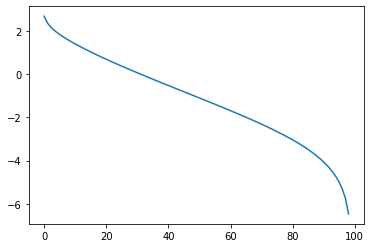

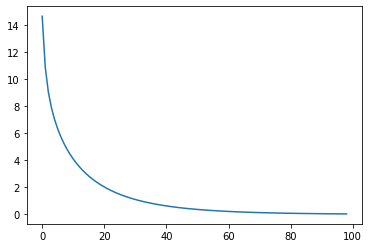

In [50]:
last = history[-1]

score = []
for image in history[:-1]:
    score.append(np.log(np.linalg.norm(image - last)))
plt.plot(score)
plt.show()

score = []
for image in history[:-1]:
    score.append(np.linalg.norm(image - last))
plt.plot(score)
plt.show()